In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pythtb import TBModel, Mesh, WFArray, Wannier, Lattice

In [2]:
def rice_mele(v, w, delta):
    lat_vecs = [[1]]
    orb_vecs = [[-1 / 4], [1 / 4]]
    lat = Lattice(lat_vecs, orb_vecs, periodic_dirs=[0])
    my_model = TBModel(lat)

    my_model.set_hop(v, 0, 1, [0])
    my_model.set_hop(w, 1, 0, [1])

    my_model.set_onsite([delta, -delta])

    return my_model

In [3]:
def berry_conn_fd(model, nk, trial_wfs):
    mesh = Mesh(['k'])
    mesh.build_grid([nk])
    flat_mesh = mesh.flat

    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    wann = Wannier(wfa)
    wann.set_trial_wfs(trial_wfs)
    wann.project(band_idxs=[0])

    # finite difference berry connection
    tilde_states = wann.tilde_states
    berry_conn = tilde_states.berry_connection(0, [0])
    berry_phase = tilde_states.berry_phase(0, [0])
    return berry_conn, berry_phase

In [4]:
def inv_sqrt_hermitian_psd(A):
    """
    Return A^{-1/2} for Hermitian PSD A using eigh, with a safe cutoff.
    """
    # Hermitize to kill numerical anti-Hermitian noise
    A = 0.5 * (A + A.conj().swapaxes(-1, -2))

    w, U = np.linalg.eigh(A)  # w >= 0 ideally
   
    inv_sqrt_w = 1.0 / np.sqrt(w)
    inv_sqrt_w = np.where(np.isfinite(inv_sqrt_w), inv_sqrt_w, 0.0)

    # U diag(inv_sqrt_w) U^\dagger
    return (U * inv_sqrt_w[..., None, :]) @ U.conj().swapaxes(-1, -2), U, w

def integrate_conn_simpson(conn, dk):
    n = conn.shape[0]
    if n < 3:  # fallback for tiny meshes
        return np.sum(conn) * dk
    if n % 2 == 1:
        # standard composite Simpson (needs odd number of points)
        return (dk/3) * (conn[0] + conn[-1]
                         + 4*np.sum(conn[1:-1:2])
                         + 2*np.sum(conn[2:-2:2]))
    else:
        # use Simpson on first n-1 points, trap on the last interval
        simpson = (dk/3) * (conn[0] + conn[-2]
                            + 4*np.sum(conn[1:-2:2])
                            + 2*np.sum(conn[2:-3:2]))
        trap_last = 0.5 * dk * (conn[-2] + conn[-1])
        return simpson + trap_last

In [5]:
def berry_conn_sp(model, nk, trial_wfs):

    ###### Build projection gauge ######
    mesh = Mesh(['k'])
    mesh.build_grid([nk], k_endpoints=False)
    flat_mesh = mesh.flat
    dk = 1/nk

    wfa = WFArray(model.lattice, mesh)
    wfa.solve_model(model)

    wann = Wannier(wfa)
    wann.set_trial_wfs(trial_wfs)
    wann.project(band_idxs=[0])

    ###### Single-point berry connection #####
    E_nk = wfa.energies
    n_states = wfa.nstates   # Total number of states
    n_occ = n_states // 2    # Number of occupied states
    occ_idxs = np.arange(n_occ) # Identify occupied bands
    cond_idxs = np.setdiff1d(np.arange(n_states), occ_idxs)  # Identify conduction bands

    # Energy eigensates (flattened spin and unflattened)
    u_nk_flat, psi_nk_flat = wfa.states(flatten_spin_axis=True, return_psi=True)  

    # Getting spin flattened occupied and conduction states and energies
    psi_occ_flat = psi_nk_flat[..., :n_occ, :]
    psi_con_flat = psi_nk_flat[..., n_occ:, :]

    twfs = wann._get_trial_wfs(trial_wfs) # trial wavefunctions

    # Overlap matrix S_nm = <psi_nk| g_m> with occupied bands
    S_occ = np.einsum("...nj, mj -> ...nm", psi_occ_flat.conj(), twfs)
    # Overlap matrix S_nm = <psi_nk| g_m> with conduction bands
    S_con = np.einsum("...nj, mj -> ...nm", psi_con_flat.conj(), twfs)

    ###### Polar decomposition #####

    W, D, Vh2 = np.linalg.svd(S_occ, full_matrices=True)
    V2 = Vh2.conj().swapaxes(-1, -2)
    # Diagonal matrix Sigma from singular values
    eye_trial = np.eye(D.shape[-1], dtype=complex)
    Sigma = np.einsum("...i,ij->...ij", D, eye_trial)   # (..., n_trial, n_trial)
    # print("Min singular value of S_occ:", np.min(D))

    U_SVD = W @ Vh2  # Unitary part of SVD
    P = V2 @ Sigma @ Vh2  # Semi-positive definite Hermitian part

    ###### Diagonalize S_occ^\dagger S_occ to get eigenvalues for inv sqrt ######

    invsqrt_O, V, evals = inv_sqrt_hermitian_psd(S_occ.conj().swapaxes(-1,-2) @ S_occ)
    Vh = V.conj().swapaxes(-1, -2)

    assert np.allclose(np.linalg.inv(P), invsqrt_O)
    assert np.allclose(V2, V)

    print("Minimum singular value of S_occ:", np.min(D))

    ####### Velocity operator in energy eigenbasis #######

    # Velocity operator in energy eigenbasis
    evecs_conj = u_nk_flat.conj()
    evecs_T = u_nk_flat.swapaxes(-1,-2)  # (n_kpts, n_beta, n_state, n_state)

    # Occupied and conduction energies
    E_occ = np.take(E_nk, occ_idxs, axis=-1)
    E_cond = np.take(E_nk, cond_idxs, axis=-1)
   
    # Compute energy denominators
    # Delta_{nm} = E_n - E_m (occ - cond)
    delta_occ_cond = E_occ[..., np.newaxis] - E_cond[..., np.newaxis, :]
    if np.any(np.isclose(delta_occ_cond, 0.0)):
        raise ZeroDivisionError(
            "Degenerate occupied/conduction bands encountered."
        )
    inv_delta_E_occ_cond = np.divide(1.0, delta_occ_cond)  # (..., n_occ, n_cond)
    print("Min energy denominator (occ-cond):", np.min(np.abs(delta_occ_cond)))

    # ------- V_mu -------

    # velocity operator
    v_k_flat = model.velocity(flat_mesh, flatten_spin_axis=True)  # shape: (dim_k, n_kpts, n_states, n_states)
    # axes for each k-dimension, expand k-dimensions
    v_k = v_k_flat.reshape(model.dim_r, nk, n_states, n_states)

    v_k_rot = np.matmul(
        evecs_conj[None, ...],  # (1, n_kpts, n_state, n_state)
        np.matmul(
            v_k,                # (dim_k, n_kpts, n_state, n_state)
            evecs_T[None, ...]  # (1, n_kpts, n_beta, n_state, n_state)
        )
    )

    v_occ_cond = np.take(np.take(v_k_rot, occ_idxs, axis=-2), cond_idxs, axis=-1)
    V_mu = v_occ_cond * inv_delta_E_occ_cond

    # ------- R_mu --------

    orb_vecs = model.orb_vecs
    r_mu_twfs = 2*np.pi * (orb_vecs.T[:, None, :] * twfs)
    R_mu = np.einsum("...nj, mj -> ...nm", psi_occ_flat.conj(), r_mu_twfs[0])

    # ------- X_mu --------

    X_mu = S_occ.conj().swapaxes(-1,-2) @ (R_mu + 1j * V_mu @ S_con)

    # ------- A_til --------

    term = -1j * X_mu
    term += term.conj().swapaxes(-1,-2)  # h.c.
    term = Vh @ term @ Vh.conj().swapaxes(-1,-2)

    sigma = np.sqrt(evals)
    for a in range(term.shape[-2]):
        for b in range(term.shape[-1]):
            term[..., a, b] *= (1 / (sigma[..., a] + sigma[..., b]))

    L_inv = Vh.conj().swapaxes(-1,-2) @ term @ Vh

    term1 = invsqrt_O @ X_mu @ invsqrt_O
    term2 = 1j * L_inv @ invsqrt_O

    # Berry connection in projection gauge
    A_til = term1 - term2

    print("Max deviation from Hermiticity:", np.amax(np.abs(A_til - A_til.conj().swapaxes(-1,-2))))
    assert np.allclose(A_til, A_til.conj().swapaxes(-1,-2)), "A_til is not Hermitian!"
    
    return A_til

In [6]:
def berry_phase(A_til):

    nk = A_til.shape[0]
    dk = 1.0 / nk
    n_occ = A_til.shape[-1]

    def expm_herm(H):
        w, V = np.linalg.eigh(H)          # small Hermitian; fast
        return V @ np.diag(np.exp(-1j * w)) @ V.conj().T

    U_W = np.eye(n_occ, dtype=complex)
    for k in range(nk):
        kp = (k + 1) % nk
        A_avg = 0.5 * (A_til[k] + A_til[kp])      # segment average → 2nd order
        U_k = expm_herm(dk * A_avg)
        U_W = U_k @ U_W                   # path ordered

    phi = -np.angle(np.linalg.det(U_W))
    phi = (phi + np.pi) % (2 * np.pi) - np.pi   # wrap to (-π, π]
    return phi

(<Figure size 640x480 with 2 Axes>, <Axes: ylabel='Energy $E(\\mathbf{{k}})$'>)

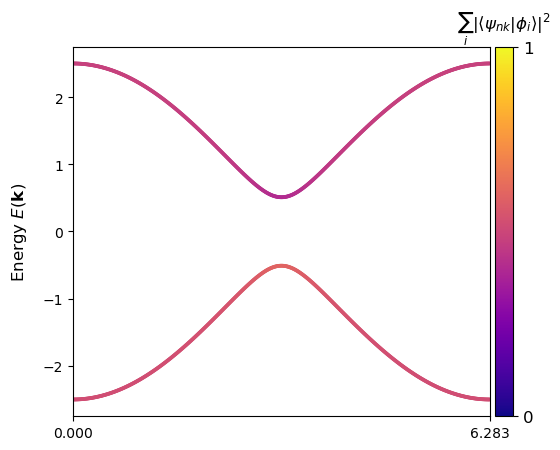

In [26]:
delta_ts = np.linspace(-0.1, 0.1, 5)
rm_model = rice_mele(1, 1.5, 0.1)
rm_model.plot_bands([0, 1], nk=601, proj_orb_idx=[1])

Calculating Berry phase for nk=10...
Minimum singular value of S_occ: 0.7071067811865474
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=20...
Minimum singular value of S_occ: 0.7071067811865472
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=50...
Minimum singular value of S_occ: 0.7071067811865472
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=100...
Minimum singular value of S_occ: 0.7071067811865471
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=10...
Minimum singular value of S_occ: 0.7071067811865474
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=20...
Minimum singular value of S_occ: 0.7071067811865472
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculati

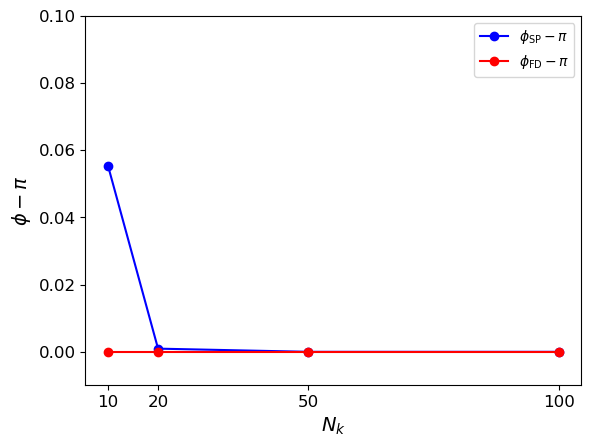

In [46]:
nks = [10, 20, 50, 100]
delta_ts = np.linspace(-0.1, 0.1, 21)

bphases_fd = np.zeros((len(nks), len(delta_ts)), dtype=float)
bphases_sp = np.zeros((len(nks), len(delta_ts)), dtype=float)
A_tils_sp = np.zeros((len(nks), len(delta_ts)), dtype=object)
A_tils_fd = np.zeros((len(nks), len(delta_ts)), dtype=object)

for i, delta_t in enumerate(delta_ts):
    rm_model = rice_mele(1, 1.5, 0)

    trial_wfs = [[(1, 1)]]

    for j, nk in enumerate(nks):
        print(f"Calculating Berry phase for nk={nk}...")

        A_til_sp = berry_conn_sp(rm_model, nk, trial_wfs)
        b_phase_sp = berry_phase(A_til_sp[0])

        A_til_fd, b_phase_fd = berry_conn_fd(rm_model, nk+1, trial_wfs)

        bphases_sp[j, i] = b_phase_sp
        bphases_fd[j, i] = b_phase_fd
        A_tils_fd[j, i] = A_til_fd
        A_tils_sp[j, i] = A_til_sp
        print()

# wrap the phases to 0 to 2π for better visualization
bphases_fd = np.mod(bphases_fd, 2*np.pi)
bphases_sp = np.mod(bphases_sp, 2*np.pi)

delta_t_idx = 0
plt.plot(nks, bphases_sp[:, delta_t_idx].real - np.pi, marker='o', c='b', label=r"$\phi_\mathrm{SP} - \pi$")
plt.plot(nks, bphases_fd[:, delta_t_idx].real - np.pi, c='r', marker='o', label=r"$\phi_\mathrm{FD} - \pi$")
# plt.hlines([-np.pi, 0, np.pi, 2*np.pi], xmin=nks[0], xmax=nks[-1], colors='gray', linestyles='dashed', alpha=0.5)
plt.ylim(-0.01, 0.1)
# plt.yscale('log')
plt.xlabel(r"$N_k$", size=14)
plt.ylabel(r"$\phi - \pi$", size=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(nks, size=12)
plt.legend()
plt.show()

In [47]:
print(bphases_sp[:, 0]-np.pi)
print(bphases_fd[:, 0]-np.pi)


[ 5.54414628e-02  9.45051152e-04  4.92704855e-09 -8.88178420e-16]
[-4.4408921e-16  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [48]:
bphases_fd = np.unwrap(bphases_fd, axis=1)
bphases_sp = np.unwrap(bphases_sp, axis=1)

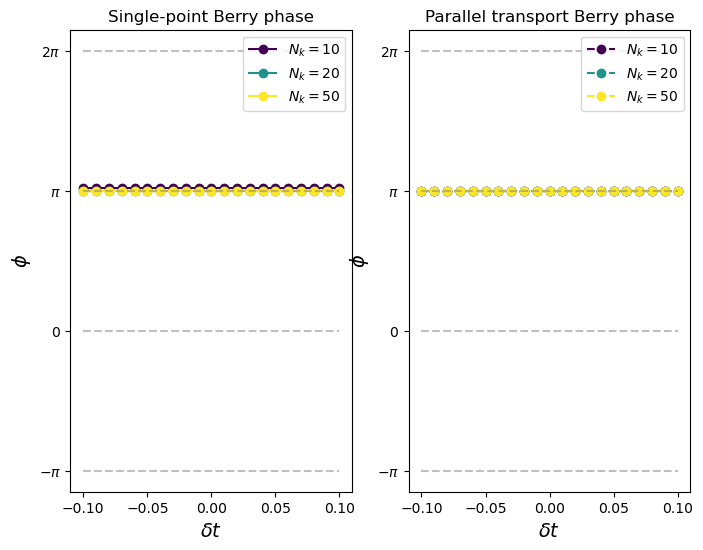

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(nks)))

for nk_idx, nk in enumerate(nks):
    ax[0].plot(delta_ts, bphases_sp[nk_idx], marker='o', c=colors[nk_idx], label=fr"$N_k={nk}$")
    ax[1].plot(delta_ts, bphases_fd[nk_idx], marker='o', c=colors[nk_idx], linestyle='dashed', label=fr"$N_k={nk}$")

ax[0].set_title("Single-point Berry phase", size=12)
ax[1].set_title("Parallel transport Berry phase", size=12)
ax[0].set_xlabel(r"$\delta t$", size=14)
ax[0].set_ylabel(r"$\phi$", size=14)
ax[0].set_yticks([-np.pi, 0, np.pi, 2*np.pi])

ax[1].set_xlabel(r"$\delta t$", size=14)
ax[1].set_ylabel(r"$\phi$", size=14)
ax[1].set_yticks([-np.pi, 0, np.pi, 2*np.pi])

ax[0].set_yticklabels([r"$-\pi$", r"$0$", r"$\pi$", r"$2\pi$"])
ax[1].set_yticklabels([r"$-\pi$", r"$0$", r"$\pi$", r"$2\pi$"])
ax[0].hlines([-np.pi, 0, np.pi, 2*np.pi], xmin=delta_ts[0], xmax=delta_ts[-1], colors='gray', linestyles='dashed', alpha=0.5)
ax[1].hlines([-np.pi, 0, np.pi, 2*np.pi], xmin=delta_ts[0], xmax=delta_ts[-1], colors='gray', linestyles='dashed', alpha=0.5)
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

Calculating Berry phase for nk=10...
Minimum singular value of S_occ: 0.7071067811865474
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=20...
Minimum singular value of S_occ: 0.7071067811865472
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0

Calculating Berry phase for nk=50...
Minimum singular value of S_occ: 0.7071067811865472
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0



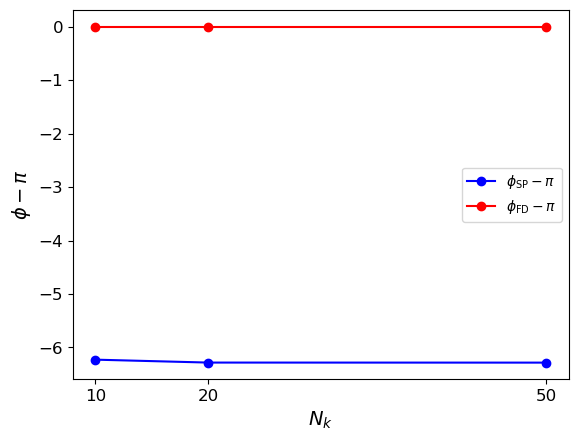

In [76]:
nks = [10, 20, 50]

bphases_fd_pi = np.zeros(len(nks), dtype=float)
bphases_sp_pi = np.zeros(len(nks), dtype=float)
A_tils_sp_pi = np.zeros(len(nks), dtype=object)
A_tils_fd_pi = np.zeros(len(nks), dtype=object)

v = 1
w = 1.5

rm_model = rice_mele(v, w, 0)

trial_wfs = [[(1, 1)]]

for j, nk in enumerate(nks):
    print(f"Calculating Berry phase for nk={nk}...")

    A_til_sp = berry_conn_sp(rm_model, nk, trial_wfs)
    b_phase_sp = berry_phase(A_til_sp[0])

    A_til_fd, b_phase_fd = berry_conn_fd(rm_model, nk+1, trial_wfs)

    bphases_sp_pi[j] = b_phase_sp
    bphases_fd_pi[j] = b_phase_fd
    A_tils_fd_pi[j] = A_til_fd
    A_tils_sp_pi[j] = A_til_sp
    print()

# bphases_fd_pi = np.unwrap(bphases_fd_pi)
# bphases_sp_pi = np.unwrap(bphases_sp_pi)
# # wrap the phases to 0 to 2π for better visualization
# b_phases_sp_pi = np.mod(bphases_sp_pi, 2*np.pi) 

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(nks, size=12)

plt.plot(nks, bphases_sp_pi - np.pi, marker='o', c='b', label=r"$\phi_\mathrm{SP} - \pi$")
plt.plot(nks, bphases_fd_pi - np.pi, c='r', marker='o', label=r"$\phi_\mathrm{FD} - \pi$")
# plt.yticks([-np.pi, 0, np.pi, 2*np.pi])
# label the y-ticks
# plt.gca().set_yticklabels([r"$-\pi$", r"$0$", r"$\pi$", r"$2\pi$"], size=12)
# plt.hlines([-np.pi, 0, np.pi, 2*np.pi], xmin=nks[0], xmax=nks[-1], colors='gray', linestyles='dashed', alpha=0.5)
# plt.yscale("log")
plt.xlabel(r"$N_k$", size=14)
plt.ylabel(r"$\phi - \pi$", size=14)
plt.legend()
plt.show()

In [77]:
A_tilde_ref = berry_conn_sp(rm_model, 10000, trial_wfs)

Minimum singular value of S_occ: 0.707106781186547
Min energy denominator (occ-cond): 1.0
Max deviation from Hermiticity: 0.0


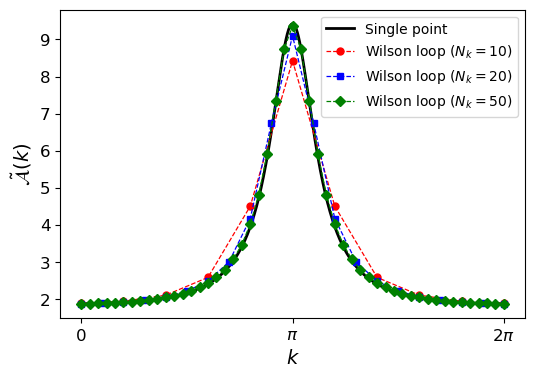

In [80]:
plt.figure(figsize=(6, 4))

k = np.linspace(0, 1, A_tilde_ref.shape[1], endpoint=False)
plt.plot(
    k,
    A_tilde_ref[0, :, 0, 0].real, 
    c='k', 
    label="Single point",
    zorder=0,
    lw=2
    )

colors_nk = ['r', 'b', 'g']
markers = ['o', 's', 'D']
for nk_idx, nk in enumerate(nks):
    k = np.linspace(0, 1, A_tils_fd_pi[nk_idx].shape[1], endpoint=True)
    plt.plot(
        k, A_tils_fd_pi[nk_idx][0, :, 0, 0].real, c=colors_nk[nk_idx], marker=markers[nk_idx], label=fr"Wilson loop ($N_k={nk}$)",
        linestyle='dashed', zorder=1, lw=0.9, ms=5
        )

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel(r"$k$", size=14)
plt.gca().set_xticks([0, 0.5, 1])
plt.gca().set_xticklabels([r"$0$", r"$\pi$", r"$2\pi$"], size=12)
plt.ylabel(r"$\tilde{\mathcal{A}}(k)$", size=14)
plt.legend(loc='upper right')
plt.savefig("ssh_berry_conn.png", bbox_inches="tight", dpi=600)

In [112]:
A_tils_fd_pi

(1, 11, 1, 1)

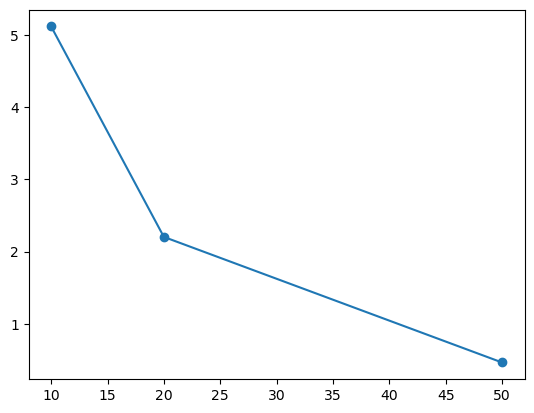

In [114]:
errors = []

for nk_idx, nk in enumerate(nks):
    error = np.max(np.abs(A_tils_fd_pi[nk_idx][0, :-1, 0,0] - A_tils_sp_pi[nk_idx][0, :, 0,0]))
    errors.append(error)

plt.plot(nks, errors, 'o-')

In [197]:
nk = 2
mesh = Mesh(['k'])
mesh.build_grid([nk])
dk = 1/nk

In [198]:
wfa = WFArray(rm_model.lattice, mesh)
wfa.solve_model(rm_model)
wfa.berry_phase(0, [0]) - np.pi

np.float64(-6.283185307179586)

In [143]:
A  = wfa.berry_connection(0, [0])[0, :, 0, 0]

In [144]:
np.sum(A)*dk/(2*np.pi)

np.complex128(57.42516272718168+0j)